## SPR X-Ray Age and Gender Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\gence\AppData\Local\Temp\ipykernel_33768\265554930.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Read the CSV files
df1 = pd.read_csv('train_age.csv')
df2 = pd.read_csv('train_gender.csv')


In [3]:
df2

,imageId,gender
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0
...,...,...
10697,10697,0
10698,10698,0
10699,10699,1
10700,10700,0


In [4]:
import os

# Set the directory where your images are located
image_directory = './train/'

# List all files in the directory
files = os.listdir(image_directory)

# Iterate over the files
for filename in files:
    # Check if the file is a PNG file
    if filename.endswith('.png'):
        # Extract the number part and remove leading zeros
        file_number = int(filename.split('.')[0])

        # Create the new file name
        new_filename = f"{file_number}.png"

        # Rename the file
        os.rename(os.path.join(image_directory, filename),
                  os.path.join(image_directory, new_filename))

print("Renaming complete.")

Renaming complete.


In [5]:
import os
import shutil

# # Paths
# root_folder = 'kaggle/kaggle/'
# train_folder = os.path.join(root_folder, 'train/')
# class1_folder = os.path.join(train_folder, 'female/')  # Gender female
# class2_folder = os.path.join(train_folder, 'male/')  # Gender male
# image_folder = 'kaggle/kaggle/train/'  # Folder where your images are currently stored

# # Create necessary directories
# os.makedirs(class1_folder, exist_ok=True)
# os.makedirs(class2_folder, exist_ok=True)

# # Iterate over the dataframe and move files
# for index, row in df2.iterrows():
#     image_name = f"{row['imageId']}.png"
#     source_path = os.path.join(image_folder, image_name)

#     # Check if the file exists to avoid errors
#     if os.path.exists(source_path):
#         if row['gender'] == 0:
#             shutil.copy(source_path, class1_folder)
#         elif row['gender'] == 1:
#             shutil.copy(source_path, class2_folder)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set up image augmentation for the training data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Update target_size to the new desired size, say 256x256
target_size = (128, 128)  # This is just an example, adjust based on your needs
batch_size = 64

# Set up the train and validation generators
train_generator = datagen.flow_from_directory(
    directory='train',  
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset="training"
)

val_generator = datagen.flow_from_directory(
    directory='train',  
    target_size=target_size,
    batch_size=batch_size,  
    class_mode='binary',  
    subset="validation"
)

Found 8563 images belonging to 2 classes.
Found 2139 images belonging to 2 classes.


In [8]:
# Assuming train_generator and val_generator are already created using flow_from_directory

# For training data
train_classes = train_generator.classes
train_class_counts = np.unique(train_classes, return_counts=True)

# For validation data
val_classes = val_generator.classes
val_class_counts = np.unique(val_classes, return_counts=True)

# Print class counts
print("Training set class counts:", dict(zip(train_generator.class_indices.keys(), train_class_counts[1])))
print("Validation set class counts:", dict(zip(val_generator.class_indices.keys(), val_class_counts[1])))


Training set class counts: {'female': 4968, 'male': 3595}
Validation set class counts: {'female': 1241, 'male': 898}


In [9]:
from sklearn.utils import class_weight

# Assuming binary classification and train_classes are the class labels for your training data
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_classes),
    y=train_classes)

class_weights_dict = dict(enumerate(class_weights))


## MobileNetV2 

In [10]:
from tensorflow.keras.layers import Dropout

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze the top layers of the base model
base_model.trainable = True

# Fine-tune from this layer onwards, adjust the layer number as needed
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Add new classifier layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Adjust dropout rate as needed

predictions = Dense(1, activation='sigmoid')(x)
predictions = tf.cast(predictions, tf.float32)  # Ensure the final predictions are float32

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3
)

# Train the model
history = model.fit(
    train_generator,
    class_weight=class_weights_dict,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Epoch 1/10


133/133 [==============================] - 649s 5s/step - loss: 0.4417 - accuracy: 0.8250 - val_loss: 0.9183 - val_accuracy: 0.7457 - lr: 0.0010
Epoch 2/10
 52/133 [==========>...................] - ETA: 4:05 - loss: 0.2519 - accuracy: 0.8963

KeyboardInterrupt: 

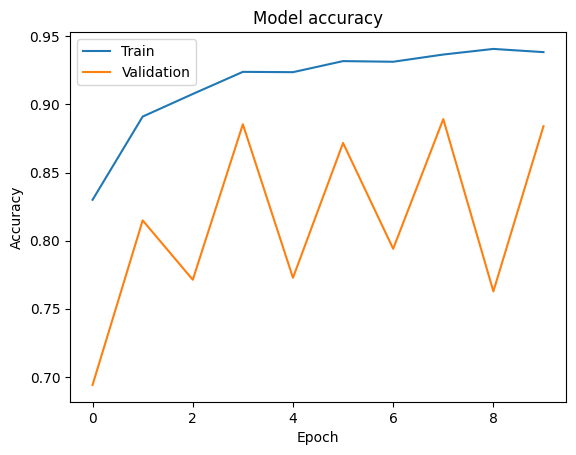

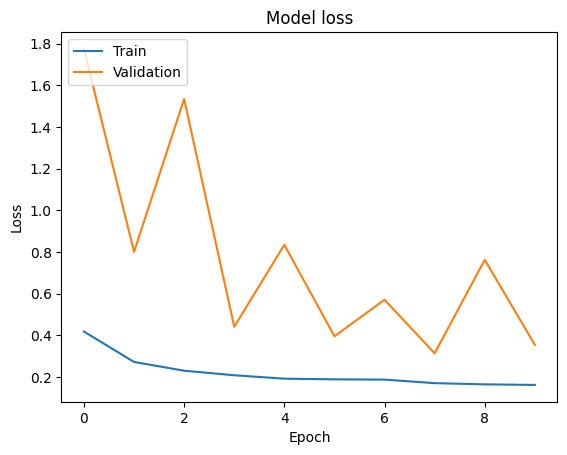

In [51]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [59]:
from sklearn.metrics import precision_recall_curve

# Assuming val_generator is your data generator for the validation set
probabilities = model.predict(val_generator, steps=np.ceil(val_generator.samples / val_generator.batch_size))


# Obtain the true labels for the validation set
true_labels = val_generator.classes

# Compute precision and recall values
precision, recall, thresholds = precision_recall_curve(true_labels, probabilities)


34/34 [==============================] - 33s 962ms/step


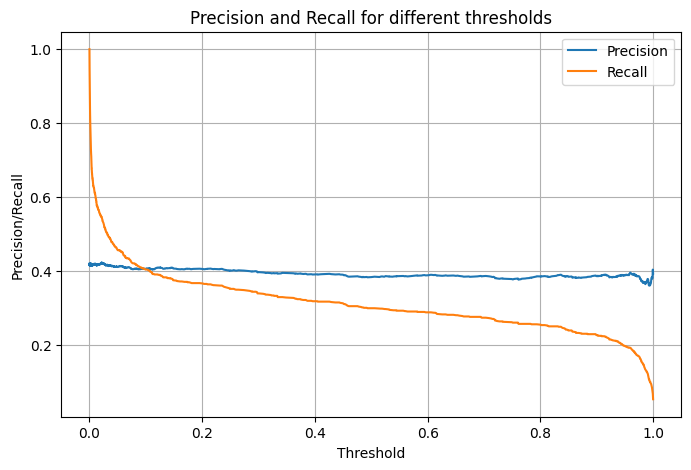

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall for different thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
from math import ceil

# Assuming you have a similar structure for test images
test_dir = 'test'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),  # Same as your training data
    batch_size=64,  # Can be a different size from your training batch size
    class_mode=None,  # Since the data is unlabeled
    shuffle=False  # To keep data in same order for later reference
)

# Make predictions
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

# For binary classification, convert probabilities to binary predictions
# Assuming a threshold of 0.5 for classification
predicted_classes = (predictions > 0.4).astype(int)

# If you need to map these predictions back to the image files
file_names = test_generator.filenames

# Create a dictionary mapping filenames to their predicted classes
predicted_labels = dict(zip(file_names, predicted_classes.flatten()))

Found 11747 images belonging to 1 classes.
184/184 [==============================] - 310s 2s/step


In [62]:
from collections import Counter

label_counts = Counter(predicted_labels.values())
print(label_counts)

Counter({1: 6298, 0: 5449})


## ResNet50

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU


fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(128,128,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(Dense(2, activation='softmax'))

fashion_model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
fashion_model.summary()


ModuleNotFoundError: No module named 'keras.layers.advanced_activations'

In [ ]:
fashion_train = fashion_model.fit(train_generator, batch_size=batch_size,epochs=10,verbose=1,validation_data=val_generator)
